# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [4-Seam RHP](#4-Seam-RHP)
    - [4-Seam LHP](#4-Seam-LHP)
    - [Cutter RHP](#Cutter-RHP)
    - [Cutter LHP](#Cutter-LHP)
    - [Sinker RHP](#Sinker-RHP)
    - [Sinker LHP](#Sinker-LHP)
    - [Slider RHP](#Slider-RHP)
    - [Slider LHP](#Slider-LHP)
    - [Curveball RHP](#Curveball-RHP)
    - [Curveball LHP](#Curveball-LHP)
    - [Changeup RHP](#Changeup-RHP)
    - [Changeup LHP](#Changeup-LHP)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 68)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwoba,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,36.0,overhead,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.262
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,3/4,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,-0.053
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,overhead,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,-0.038
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,overhead,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.028
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,36.0,overhead,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.218


# Cleaning / EDA

### Features

In [3]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'slot', 'release_extension', 'rv']]
# 'plate_x', 'plate_z'
#'stand'

In [4]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
print('Fastball shape:', fastball.shape)
breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
print('Breaking Ball:', breaking_ball.shape)
offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]
print('Off-speed shape:', offspeed.shape)
rhp = features.loc[features['p_throws'] == 'R']
print('RHP shape:', rhp.shape)
lhp = features.loc[features['p_throws'] == 'L']
print('LHP shape:', lhp.shape)
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
print('RHP Fastball shape:', rhp_fastball.shape)
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
print('LHP Fastball shape:', lhp_fastball.shape)
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
print('RHP Breaking Ball shape:', rhp_breaking_ball.shape)
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
print('LHP Breaking Ball shape:', lhp_breaking_ball.shape)
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
print('RHP Offspeed shape:', rhp_offspeed.shape)
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
print('LHP Offspeed shape:', lhp_offspeed.shape)

Fastball shape: (406250, 13)
Breaking Ball: (207975, 13)
Off-speed shape: (91171, 13)
RHP shape: (496493, 13)
LHP shape: (208903, 13)
RHP Fastball shape: (283224, 13)
LHP Fastball shape: (123026, 13)
RHP Breaking Ball shape: (152378, 13)
LHP Breaking Ball shape: (55597, 13)
RHP Offspeed shape: (60891, 13)
LHP Offspeed shape: (30280, 13)


# Random Forest Regression Model

# Grouped Pitches

## Fastball RHP

#### 4-Seam, Cutter, Sinker

In [102]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['rv'])
y = features_fastball_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fastball_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.034
MSE: 0.079
RMSE: 0.281
MAE: 0.158 

R2 Score: 0.633
MSE: 0.028
RMSE: 0.168
MAE: 0.085


### RHP Fastball Actual & Predicted Values

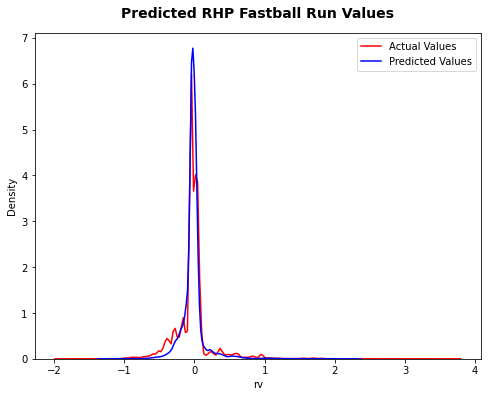

In [103]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV Table

In [104]:
rhp_fastball['FF_count'] = [1 if x == 'FF' else 0 for x in rhp_fastball['pitch_type']]
rhp_fastball['SI_count'] = [1 if x == 'SI' else 0 for x in rhp_fastball['pitch_type']]
rhp_fastball['FC_count'] = [1 if x == 'FC' else 0 for x in rhp_fastball['pitch_type']]

rhp_fastball['xRV'] = pred
rhp_fastball['xRV'] = round(rhp_fastball['xRV'], 3)
grouped_fastball_r = rhp_fastball.groupby(['player_name', 'pitch_type'], as_index = False)['FF_count', 'SI_count',
                                                                                           'FC_count', 'velo',
                                                                                           'pfx_x', 'pfx_z',
                                                                                           'arm_angle',
                                                                                           'release_extension',
                                                                                           'rv', 'xRV'].sum()
grouped_fastball_r = pd.DataFrame(grouped_fastball_r)
grouped_fastball_r['RV/100'] = round(((grouped_fastball_r['rv'] / (grouped_fastball_r['FF_count'] +
                                                                   grouped_fastball_r['SI_count'] +
                                                                   grouped_fastball_r['FC_count'])) * 100), 2)
grouped_fastball_r['xRV/100'] = round(((grouped_fastball_r['xRV'] / (grouped_fastball_r['FF_count'] +
                                                                     grouped_fastball_r['SI_count'] +
                                                                     grouped_fastball_r['FC_count'])) * 100), 2)

fastball_r_group = pd.merge(rhp_fastball, grouped_fastball_r, how = 'left', on = ['player_name'])
fastball_r_group.head()
fastball_drop_cols = ['pitch_type_x', 'FF_count_x', 'SI_count_x', 'FC_count_x', 'velo_y', 'pfx_x_y', 'pfx_z_y', 
                      'arm_angle_y', 'release_extension_y']
fastball_r_group.drop(columns = fastball_drop_cols, inplace = True)
col_dict_fastball = {
    'pitch_type_y': 'pitch_type',
    'rv_x': 'rv_above_outs',
    'xRV_x': 'xrv_above_outs',
    'FF_count_y': 'FF_count',
    'SI_count_y': 'SI_count',
    'FC_count_y': 'FC_count',
    'velo_x': 'velo',
    'pfx_x_x': 'pfx_x',
    'pfx_z_x': 'pfx_z',
    'arm_angle_x': 'arm_angle',
    'release_extension_x': 'release_extension',
    'rv_y': 'RV',
    'xRV_y': 'xRV'
}
fastball_r_group.rename(columns = col_dict_fastball, inplace = True)
fastball_r_rv_table = fastball_r_group.groupby(['player_name', 'p_throws', 'pitch_type', 'FF_count', 
                                                'SI_count', 'FC_count'], 
                                               as_index = False)['velo', 'pfx_x', 'pfx_z', 'arm_angle', 
                                                                 'release_extension', 'RV', 
                                                                 'RV/100', 'xRV', 'xRV/100'].mean()
fastball_r_rv_table['velo'] = round(fastball_r_rv_table['velo'], 1)
fastball_r_rv_table['pfx_x'] = round(fastball_r_rv_table['pfx_x'], 2)
fastball_r_rv_table['pfx_z'] = round(fastball_r_rv_table['pfx_z'], 2)
fastball_r_rv_table['arm_angle'] = round(fastball_r_rv_table['arm_angle'], 2)
fastball_r_rv_table['release_extension'] = round(fastball_r_rv_table['release_extension'], 2)

fastball_r_rv_table = pd.DataFrame(fastball_r_rv_table)
print(fastball_r_rv_table.shape)
fastball_r_rv_table.head()

(1115, 15)


,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207,0,0,92.6,9.58,17.19,43.30,6.19,4.322,2.09,0.786,0.38
1,"Abreu, Albert",R,FF,103,0,0,97.9,14.14,13.97,40.93,6.46,-2.370,-2.30,-3.191,-3.10
2,"Abreu, Albert",R,SI,0,212,0,97.9,14.14,13.97,40.93,6.46,-2.181,-1.03,-7.404,-3.49
3,"Abreu, Bryan",R,FF,310,0,0,95.7,8.04,17.04,28.73,6.33,-4.108,-1.33,-4.576,-1.48
4,"Abreu, Bryan",R,SI,0,2,0,95.7,8.04,17.04,28.73,6.33,-0.025,-1.25,-0.054,-2.70


### RHP Fastball RV by Strike Zone

In [105]:
#plt.figure(figsize = (8, 6))
#
#plt.hexbin(rhp_fastball['plate_x'], rhp_fastball['plate_z'], C = pred, 
#           cmap = 'coolwarm', gridsize = 20, mincnt = 50)
#plt.xlabel('plate_x'), plt.ylabel('plate_z'), plt.colorbar()
##plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
#plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
#plt.title('RHP Fastball RV by Strike Zone - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV by Velo & Spin Rate

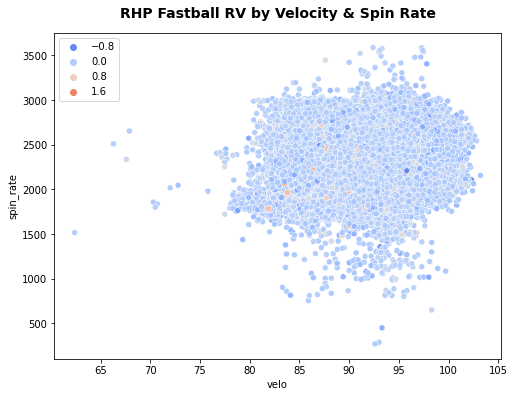

In [106]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_fastball, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('RHP Fastball RV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV by HB & VB

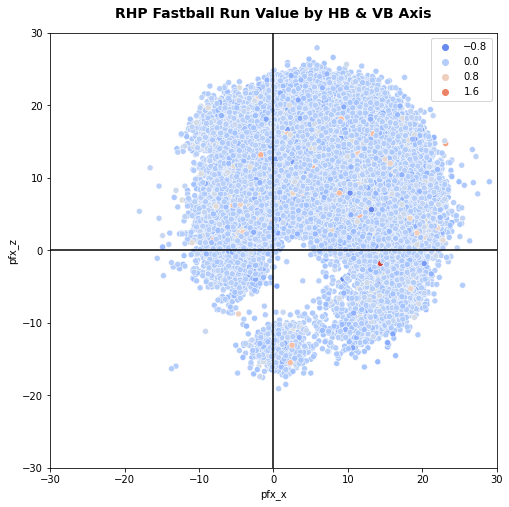

In [107]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = rhp_fastball, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Fastball Run Value by HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball RV by Release Point

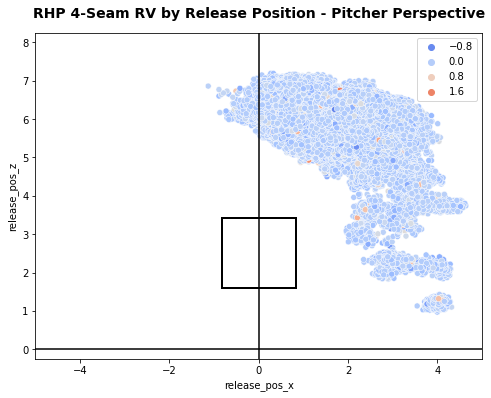

In [108]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_fastball, x = 'release_pos_x', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP 4-Seam RV by Release Position - Pitcher Perspective', fontsize = 14, fontweight ='bold', pad = 15);

### RHP Fastball RV by Release Extension

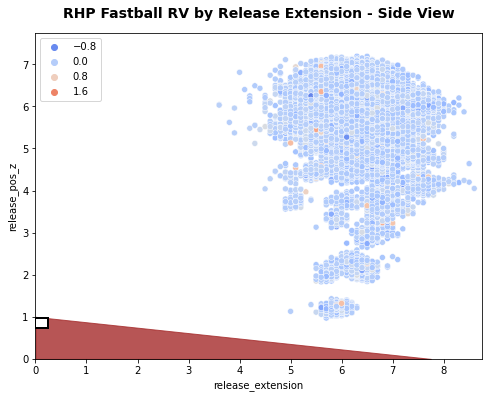

In [109]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_fastball, x = 'release_extension', y = 'release_pos_z', 
                hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Fastball RV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

## Fastball LHP

#### 4-Seam, Cutter, Sinker

In [110]:
features_fastball_l = lhp_fastball.select_dtypes([np.number])
X = features_fastball_l.drop(columns = ['rv'])
y = features_fastball_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fastball_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_fastball_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.038
MSE: 0.077
RMSE: 0.278
MAE: 0.158 

R2 Score: 0.632
MSE: 0.027
RMSE: 0.166
MAE: 0.084


### LHP Fastball Actual & Predicted Values

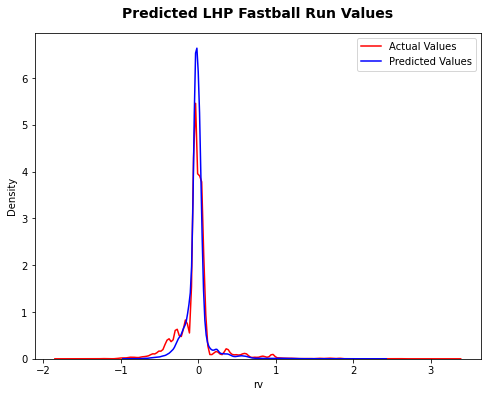

In [111]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV Table

In [112]:
lhp_fastball['FF_count'] = [1 if x == 'FF' else 0 for x in lhp_fastball['pitch_type']]
lhp_fastball['SI_count'] = [1 if x == 'SI' else 0 for x in lhp_fastball['pitch_type']]
lhp_fastball['FC_count'] = [1 if x == 'FC' else 0 for x in lhp_fastball['pitch_type']]

lhp_fastball['xRV'] = pred
lhp_fastball['xRV'] = round(ff_l['xRV'], 3)
grouped_fastball_l = lhp_fastball.groupby(['player_name', 'pitch_type'], as_index = False)['FF_count', 'SI_count',
                                                                                           'FC_count', 'velo',
                                                                                           'pfx_x', 'pfx_z',
                                                                                           'arm_angle',
                                                                                           'release_extension',
                                                                                           'rv', 'xRV'].sum()
grouped_fastball_l = pd.DataFrame(grouped_fastball_l)
grouped_fastball_l['RV/100'] = round(((grouped_fastball_l['rv'] / (grouped_fastball_l['FF_count'] +
                                                                   grouped_fastball_l['SI_count'] +
                                                                   grouped_fastball_l['FC_count'])) * 100), 2)

grouped_fastball_l['xRV/100'] = round(((grouped_fastball_l['xRV'] / (grouped_fastball_l['FF_count'] +
                                                                     grouped_fastball_l['SI_count'] +
                                                                     grouped_fastball_l['FC_count'])) * 100), 2)

fastball_l_group = pd.merge(lhp_fastball, grouped_fastball_l, how = 'left', on = ['player_name'])
fastball_l_group.drop(columns = fastball_drop_cols, inplace = True)
fastball_l_group.rename(columns = col_dict_fastball, inplace = True)
fastball_l_rv_table = fastball_l_group.groupby(['player_name', 'p_throws', 'pitch_type', 'FF_count', 
                                                'SI_count', 'FC_count'], 
                                               as_index = False)['velo', 'pfx_x', 'pfx_z', 'arm_angle', 
                                                                 'release_extension', 'RV', 
                                                                 'RV/100', 'xRV', 'xRV/100'].mean()
fastball_l_rv_table['velo'] = round(fastball_l_rv_table['velo'], 1)
fastball_l_rv_table['pfx_x'] = round(fastball_l_rv_table['pfx_x'], 2)
fastball_l_rv_table['pfx_z'] = round(fastball_l_rv_table['pfx_z'], 2)
fastball_l_rv_table['arm_angle'] = round(fastball_l_rv_table['arm_angle'], 2)
fastball_l_rv_table['release_extension'] = round(fastball_l_rv_table['release_extension'], 2)

fastball_l_rv_table = pd.DataFrame(fastball_l_rv_table)
print(fastball_l_rv_table.shape)
fastball_l_rv_table.head()

(423, 15)


,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,FC,0,0,16,91.4,-10.86,12.33,15.31,5.84,-0.544,-3.40,0.000,0.00
1,"Abad, Fernando",L,FF,18,0,0,91.4,-10.86,12.33,15.31,5.84,2.284,12.69,1.715,9.53
2,"Abad, Fernando",L,SI,0,141,0,91.4,-10.86,12.33,15.31,5.84,-4.652,-3.30,0.000,0.00
3,"Aguilar, Miguel",L,FF,62,0,0,91.4,-4.82,15.73,28.60,6.02,-1.774,-2.86,-0.322,-0.52
4,"Akin, Keegan",L,FF,1009,0,0,92.0,-10.75,18.06,77.30,5.88,-43.472,-4.31,-43.853,-4.35


### LHP Fastball RV by Strike Zone

In [113]:
#plt.figure(figsize = (8, 6))
#
#plt.hexbin(lhp_fastball['plate_x'], lhp_fastball['plate_z'], C = pred, 
#           cmap = 'coolwarm', gridsize = 20, mincnt = 50)
#plt.xlabel('plate_x'), plt.ylabel('plate_z'), plt.colorbar()
#plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
#plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
#plt.title('LHP Fastball RV by Strike Zone - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV by Velo & Spin Rate

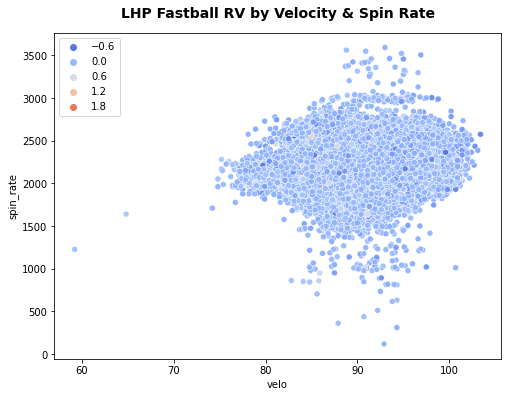

In [114]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_fastball, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('LHP Fastball RV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV by HB & VB

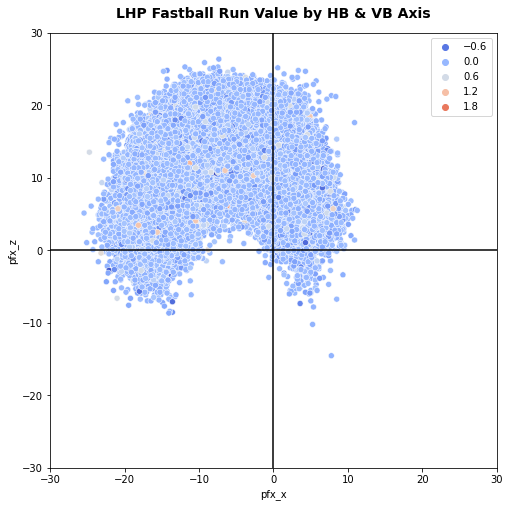

In [115]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = lhp_fastball, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Fastball Run Value by HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball RV by Release Point

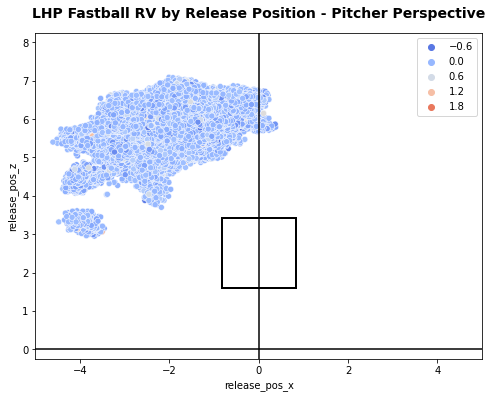

In [116]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_fastball, x = 'release_pos_x', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Fastball RV by Release Position - Pitcher Perspective', fontsize = 14, fontweight ='bold', 
          pad = 15);

### LHP Fastball by Release Extension

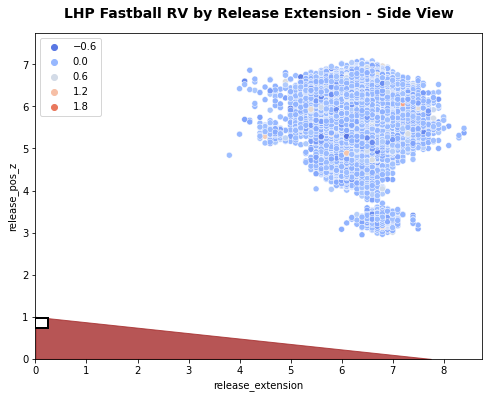

In [117]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_fastball, x = 'release_extension', y = 'release_pos_z', 
                hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Fastball RV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [118]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.035
MSE: 0.076
RMSE: 0.275
MAE: 0.158 

R2 Score: 0.634
MSE: 0.027
RMSE: 0.164
MAE: 0.085


### RHP Breaking Ball Actual & Predicted Values

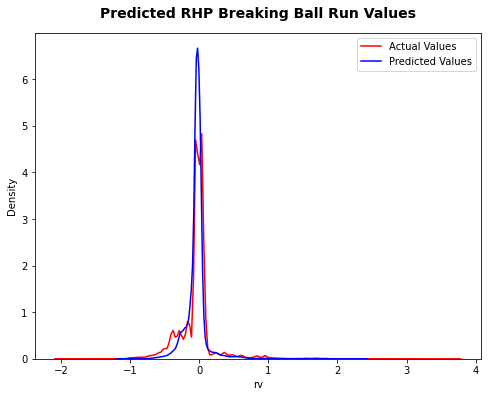

In [119]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV Table

In [120]:
rhp_breaking_ball['CU_count'] = [1 if x == 'CU' else 0 for x in rhp_breaking_ball['pitch_type']]
rhp_breaking_ball['SL_count'] = [1 if x == 'SL' else 0 for x in rhp_breaking_ball['pitch_type']]
rhp_breaking_ball['KC_count'] = [1 if x == 'KC' else 0 for x in rhp_breaking_ball['pitch_type']]

rhp_breaking_ball['xRV'] = pred
rhp_breaking_ball['xRV'] = round(rhp_breaking_ball['xRV'], 3)
grouped_bb_r = rhp_breaking_ball.groupby(['player_name', 'pitch_type'], as_index = False)['CU_count', 'SL_count',
                                                                                          'KC_count', 'velo',
                                                                                          'pfx_x', 'pfx_z',
                                                                                          'arm_angle',
                                                                                          'release_extension',
                                                                                          'rv', 'xRV'].sum()
grouped_bb_r = pd.DataFrame(grouped_bb_r)
grouped_bb_r['RV/100'] = round(((grouped_bb_r['rv'] / (grouped_bb_r['CU_count'] +
                                                       grouped_bb_r['SL_count'] +
                                                       grouped_bb_r['KC_count'])) * 100), 2)
grouped_bb_r['xRV/100'] = round(((grouped_bb_r['xRV'] / (grouped_bb_r['CU_count'] +
                                                         grouped_bb_r['SL_count'] +
                                                         grouped_bb_r['KC_count'])) * 100), 2)
bb_r_group = pd.merge(rhp_breaking_ball, grouped_bb_r, how = 'left', on = ['player_name'])
bb_drop_cols = ['pitch_type_x', 'CU_count_x', 'SL_count_x', 'KC_count_x', 'velo_y', 'pfx_x_y', 
                'pfx_z_y', 'arm_angle_y', 'release_extension_y']
bb_r_group.drop(columns = bb_drop_cols, inplace = True)
col_dict_bb = {
    'pitch_type_y': 'pitch_type',
    'rv_x': 'rv_above_outs',
    'xRV_x': 'xrv_above_outs',
    'CU_count_y': 'CU_count',
    'SL_count_y': 'SL_count',
    'KC_count_y': 'KC_count',
    'velo_x': 'velo',
    'pfx_x_x': 'pfx_x',
    'pfx_z_x': 'pfx_z',
    'arm_angle_x': 'arm_angle',
    'release_extension_x': 'release_extension',
    'rv_y': 'RV',
    'xRV_y': 'xRV'
}
bb_r_group.rename(columns = col_dict_bb, inplace = True)
bb_r_rv_table = bb_r_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CU_count', 'SL_count', 'KC_count'], 
                                   as_index = False)['velo', 'pfx_x', 'pfx_z', 'arm_angle', 
                                                     'release_extension', 'RV', 
                                                     'RV/100', 'xRV', 'xRV/100'].mean()
bb_r_rv_table['velo'] = round(bb_r_rv_table['velo'], 1)
bb_r_rv_table['pfx_x'] = round(bb_r_rv_table['pfx_x'], 2)
bb_r_rv_table['pfx_z'] = round(bb_r_rv_table['pfx_z'], 2)
bb_r_rv_table['arm_angle'] = round(bb_r_rv_table['arm_angle'], 2)
bb_r_rv_table['release_extension'] = round(bb_r_rv_table['release_extension'], 2)

bb_r_rv_table = pd.DataFrame(bb_r_rv_table)
print(bb_r_rv_table.shape)
bb_r_rv_table.head()

(900, 15)


,player_name,p_throws,pitch_type,CU_count,SL_count,KC_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CU,58,0,0,86.0,0.79,-2.94,42.41,5.94,-5.477,-9.44,-3.443,-5.94
1,"Abbott, Cory",R,SL,0,63,0,86.0,0.79,-2.94,42.41,5.94,-0.220,-0.35,1.785,2.83
2,"Abreu, Albert",R,CU,1,0,0,87.2,-2.86,3.44,41.49,6.27,0.024,2.40,-0.065,-6.50
3,"Abreu, Albert",R,SL,0,224,0,87.2,-2.86,3.44,41.49,6.27,-7.504,-3.35,-8.153,-3.64
4,"Abreu, Bryan",R,CU,121,0,0,88.2,-4.95,-4.71,32.98,6.22,-0.234,-0.19,-5.412,-4.47


### RHP Breaking Ball RV by Strike Zone

In [121]:
#plt.figure(figsize = (8, 6))
#
#plt.hexbin(rhp_breaking_ball['plate_x'], rhp_breaking_ball['plate_z'], C = pred, 
#           cmap = 'coolwarm', gridsize = 20, mincnt = 50)
#plt.xlabel('plate_x'), plt.ylabel('plate_z'), plt.colorbar()
#plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
#plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
#plt.title('RHP Breaking Ball RV by Strike Zone - Pitcher Perspective', fontsize = 14, fontweight = 'bold', 
#          pad = 15);

### RHP Breaking Ball RV by Velo & Spin Rate

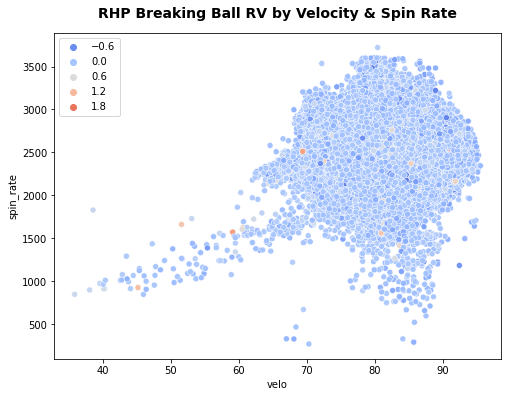

In [122]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_breaking_ball, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('RHP Breaking Ball RV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV by HB & VB

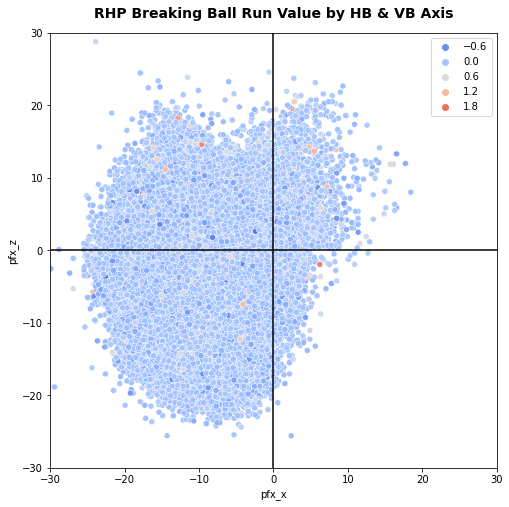

In [123]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = rhp_breaking_ball, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Breaking Ball Run Value by HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball RV by Release Point

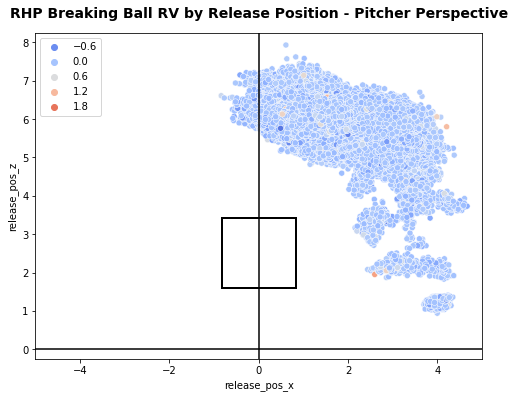

In [124]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_breaking_ball, x = 'release_pos_x', y = 'release_pos_z', hue = pred, 
                palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Breaking Ball RV by Release Position - Pitcher Perspective', fontsize = 14, fontweight ='bold', 
          pad = 15);

## Breaking Ball LHP

#### Slider, Curveball, Knuckle Curve

In [125]:
features_bb_l = lhp_breaking_ball.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['rv'])
y = features_bb_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.041
MSE: 0.079
RMSE: 0.281
MAE: 0.16 

R2 Score: 0.625
MSE: 0.028
RMSE: 0.167
MAE: 0.086


### LHP Breaking Ball Actual & Predicted Values

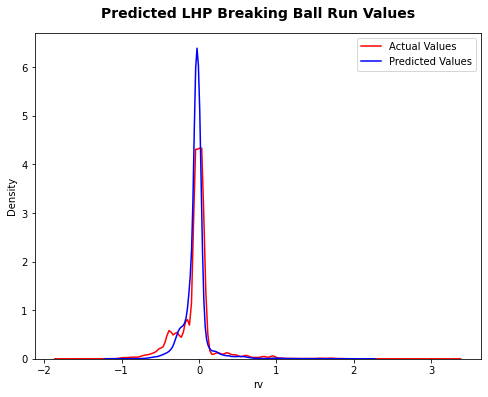

In [126]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV Table

In [127]:
lhp_breaking_ball['CU_count'] = [1 if x == 'CU' else 0 for x in lhp_breaking_ball['pitch_type']]
lhp_breaking_ball['SL_count'] = [1 if x == 'SL' else 0 for x in lhp_breaking_ball['pitch_type']]
lhp_breaking_ball['KC_count'] = [1 if x == 'KC' else 0 for x in lhp_breaking_ball['pitch_type']]

lhp_breaking_ball['xRV'] = pred
lhp_breaking_ball['xRV'] = round(lhp_breaking_ball['xRV'], 3)
grouped_bb_l = lhp_breaking_ball.groupby(['player_name', 'pitch_type'], as_index = False)['CU_count', 'SL_count',
                                                                                          'KC_count', 'velo',
                                                                                          'pfx_x', 'pfx_z',
                                                                                          'arm_angle',
                                                                                          'release_extension',
                                                                                          'rv', 'xRV'].sum()
grouped_bb_l = pd.DataFrame(grouped_bb_l)
grouped_bb_l['RV/100'] = round(((grouped_bb_l['rv'] / (grouped_bb_l['CU_count'] +
                                                       grouped_bb_l['SL_count'] +
                                                       grouped_bb_l['KC_count'])) * 100), 2)
grouped_bb_l['xRV/100'] = round(((grouped_bb_l['xRV'] / (grouped_bb_l['CU_count'] +
                                                         grouped_bb_l['SL_count'] +
                                                         grouped_bb_l['KC_count'])) * 100), 2)
bb_l_group = pd.merge(lhp_breaking_ball, grouped_bb_l, how = 'left', on = ['player_name'])
bb_l_group.drop(columns = bb_drop_cols, inplace = True)
bb_l_group.rename(columns = col_dict_bb, inplace = True)
bb_l_rv_table = bb_l_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CU_count', 'SL_count', 'KC_count'], 
                                   as_index = False)['velo', 'pfx_x', 'pfx_z', 'arm_angle', 
                                                     'release_extension', 'RV', 
                                                     'RV/100', 'xRV', 'xRV/100'].mean()
bb_l_rv_table['velo'] = round(bb_l_rv_table['velo'], 1)
bb_l_rv_table['pfx_x'] = round(bb_l_rv_table['pfx_x'], 2)
bb_l_rv_table['pfx_z'] = round(bb_l_rv_table['pfx_z'], 2)
bb_l_rv_table['arm_angle'] = round(bb_l_rv_table['arm_angle'], 2)
bb_l_rv_table['release_extension'] = round(bb_l_rv_table['release_extension'], 2)

bb_l_rv_table = pd.DataFrame(bb_l_rv_table)
print(bb_l_rv_table.shape)
bb_l_rv_table.head()

(323, 15)


,player_name,p_throws,pitch_type,CU_count,SL_count,KC_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,KC,0,0,78,76.4,7.23,-9.18,18.80,5.63,0.169,0.22,-0.193,-0.25
1,"Aguilar, Miguel",L,CU,19,0,0,83.2,9.66,5.46,37.13,5.92,-3.558,-18.73,-2.997,-15.77
2,"Aguilar, Miguel",L,SL,0,20,0,83.2,9.66,5.46,37.13,5.92,1.454,7.27,2.233,11.16
3,"Akin, Keegan",L,CU,69,0,0,82.9,4.73,2.01,84.38,5.85,-1.034,-1.50,0.225,0.33
4,"Akin, Keegan",L,SL,0,344,0,82.9,4.73,2.01,84.38,5.85,-0.118,-0.03,3.849,1.12


### LHP Breaking Ball RV by Strike Zone

In [128]:
#plt.figure(figsize = (8, 6))
#
#plt.hexbin(lhp_breaking_ball['plate_x'], lhp_breaking_ball['plate_z'], C = pred, cmap = 'coolwarm', 
#           gridsize = 20, mincnt = 50)
#plt.xlabel('plate_x'), plt.ylabel('plate_z'), plt.colorbar()
#plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
#plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
#plt.title('LHP Breaking Ball RV by Strike Zone - Pitcher Perspective', fontsize = 14, fontweight = 'bold', 
#          pad = 15);

### LHP Breaking Ball RV by Velo & Spin Rate

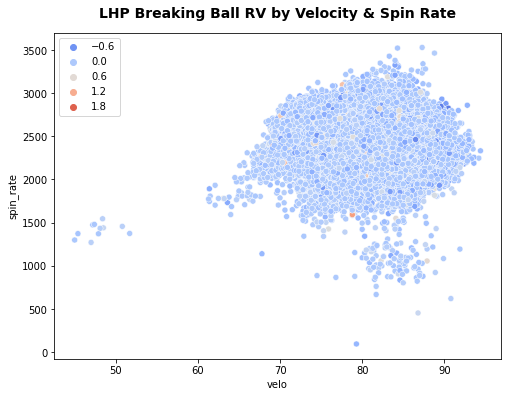

In [129]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_breaking_ball, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('LHP Breaking Ball RV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV by HB & VB

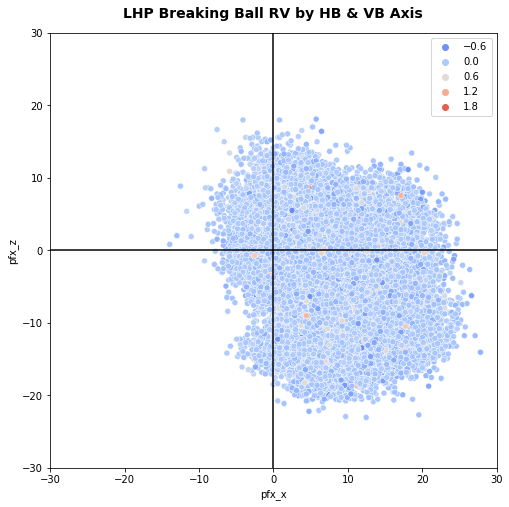

In [130]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = lhp_breaking_ball, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Breaking Ball RV by HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball RV by Release Point

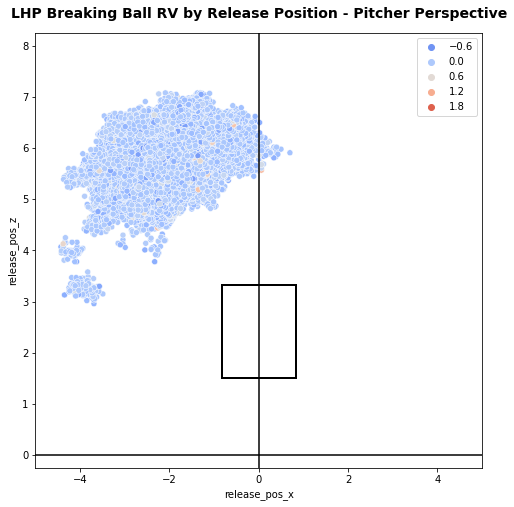

In [131]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = lhp_breaking_ball, x = 'release_pos_x', y = 'release_pos_z', 
                hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Breaking Ball RV by Release Position - Pitcher Perspective', fontsize=14, fontweight='bold', 
          pad=15);

### LHP Breaking Ball RV by Release Extension

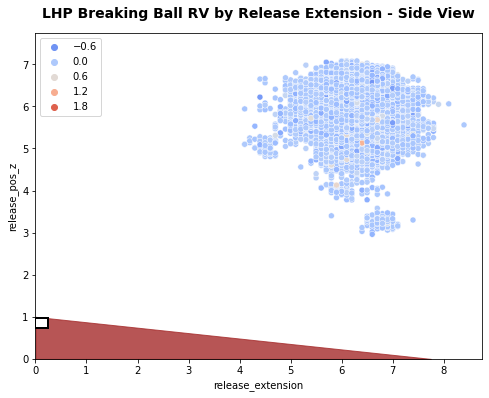

In [132]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_breaking_ball, x = 'release_extension', y = 'release_pos_z', 
                hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Breaking Ball RV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed RHP

#### Changeup, Splitter

In [133]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.041
MSE: 0.08
RMSE: 0.282
MAE: 0.166 

R2 Score: 0.631
MSE: 0.028
RMSE: 0.168
MAE: 0.089


### RHP Off-Speed Actual & Predicted Run Values

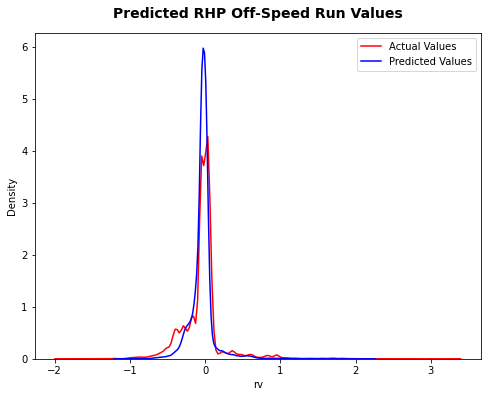

In [134]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV Table

In [135]:
rhp_offspeed['CH_count'] = [1 if x == 'CH' else 0 for x in rhp_offspeed['pitch_type']]
rhp_offspeed['FS_count'] = [1 if x == 'FS' else 0 for x in rhp_offspeed['pitch_type']]

rhp_offspeed['xRV'] = pred
rhp_offspeed['xRV'] = round(rhp_offspeed['xRV'], 3)
grouped_os_r = rhp_offspeed.groupby(['player_name', 'pitch_type'], as_index = False)['CH_count', 'FS_count',
                                                                                     'pfx_x', 'pfx_z',
                                                                                     'velo', 'arm_angle',
                                                                                     'release_extension',
                                                                                     'rv', 'xRV'].sum()
grouped_os_r = pd.DataFrame(grouped_os_r)
grouped_os_r['RV/100'] = round(((grouped_os_r['rv'] / (grouped_os_r['CH_count'] +
                                                       grouped_os_r['FS_count'])) * 100), 2)
grouped_os_r['xRV/100'] = round(((grouped_os_r['xRV'] / (grouped_os_r['CH_count'] +
                                                         grouped_os_r['FS_count'])) * 100), 2)
os_r_group = pd.merge(rhp_offspeed, grouped_os_r, how = 'left', on = ['player_name'])
os_drop_cols = ['pitch_type_x', 'CH_count_x', 'FS_count_x', 'velo_y', 'pfx_x_y', 'pfx_z_y', 
                'arm_angle_y', 'release_extension_y']
os_r_group.drop(columns = os_drop_cols, inplace = True)
col_dict_os = {
    'pitch_type_y': 'pitch_type',
    'rv_x': 'rv_above_outs',
    'xRV_x': 'xrv_above_outs',
    'CH_count_y': 'CH_count',
    'FS_count_y': 'FS_count',
    'velo_x': 'velo',
    'pfx_x_x': 'pfx_x',
    'pfx_z_x': 'pfx_z',
    'arm_angle_x': 'arm_angle',
    'release_extension_x': 'release_extension',
    'rv_y': 'RV',
    'xRV_y': 'xRV'
}
os_r_group.rename(columns = col_dict_os, inplace = True)
os_r_rv_table = os_r_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count'], 
                                   as_index = False)['velo', 'pfx_x', 'pfx_z', 'arm_angle', 
                                                     'release_extension', 'RV', 
                                                     'RV/100', 'xRV', 'xRV/100'].mean()
os_r_rv_table['velo'] = round(os_r_rv_table['velo'], 1)
os_r_rv_table['pfx_x'] = round(os_r_rv_table['pfx_x'], 2)
os_r_rv_table['pfx_z'] = round(os_r_rv_table['pfx_z'], 2)
os_r_rv_table['arm_angle'] = round(os_r_rv_table['arm_angle'], 2)
os_r_rv_table['release_extension'] = round(os_r_rv_table['release_extension'], 2)

os_r_rv_table = pd.DataFrame(os_r_rv_table)
print(os_r_rv_table.shape)
os_r_rv_table.head()

(522, 14)


,player_name,p_throws,pitch_type,CH_count,FS_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,CH,23,0,87.0,13.90,12.34,40.3,6.05,-0.927,-4.03,-0.650,-2.83
1,"Abreu, Albert",R,CH,102,0,88.2,16.82,8.61,38.6,6.47,0.007,0.01,-1.234,-1.21
2,"Acevedo, Domingo",R,CH,37,0,86.0,16.94,8.73,27.8,5.99,-4.047,-10.94,-3.182,-8.60
3,"Adam, Jason",R,CH,22,0,87.2,15.81,2.72,33.1,6.57,0.840,3.82,0.288,1.31
4,"Adon, Joan",R,CH,6,0,87.1,16.78,9.28,43.6,6.25,-0.041,-0.68,-0.182,-3.03


### RHP Off-Speed RV by Strike Zone

In [136]:
#plt.figure(figsize = (8, 6))
#
#plt.hexbin(rhp_offspeed['plate_x'], rhp_offspeed['plate_z'], C = pred, cmap = 'coolwarm', 
#           gridsize = 20, mincnt = 50)
#plt.xlabel('plate_x'), plt.ylabel('plate_z'), plt.colorbar()
#plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
#plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
#plt.title('RHP Off-Speed RV by Strike Zone - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV by Velo & Spin Rate

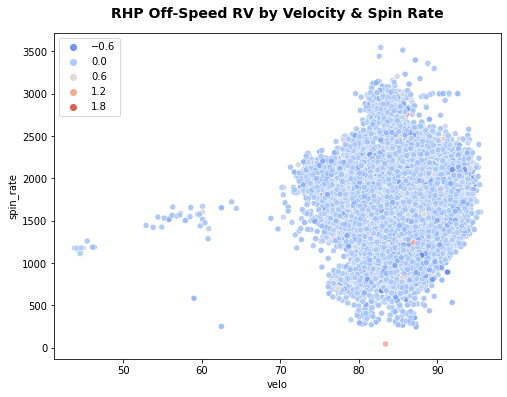

In [137]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_offspeed, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('RHP Off-Speed RV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV by HB & VB

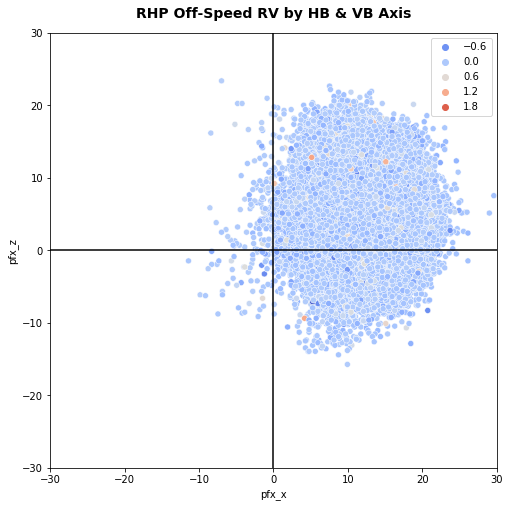

In [138]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = rhp_offspeed, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Off-Speed RV by HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off-Speed RV by Release Position

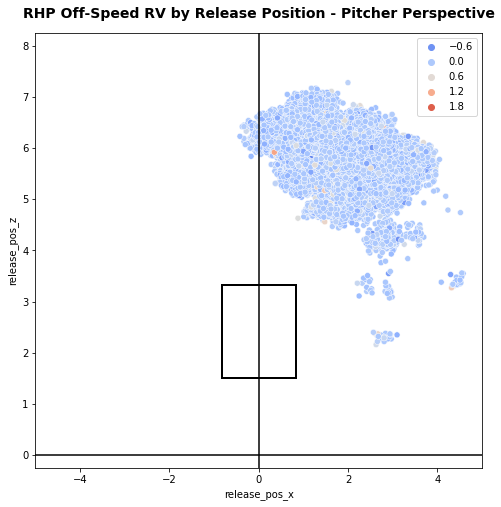

In [139]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = rhp_offspeed, x = 'release_pos_x', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('RHP Off-Speed RV by Release Position - Pitcher Perspective', fontsize=14, fontweight='bold', pad=15);

### RHP Off-Speed RV by Release Extension

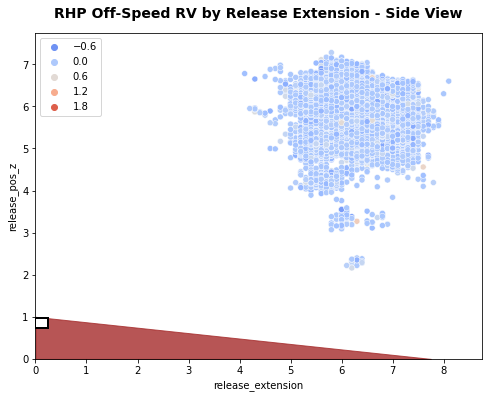

In [140]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = rhp_offspeed, x = 'release_extension', y = 'release_pos_z', 
                hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('RHP Off-Speed RV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed LHP

#### Changeup, Splitter

In [141]:
features_os_l = lhp_offspeed.select_dtypes([np.number])
X = features_os_l.drop(columns = ['rv'])
y = features_os_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('MSE:', round((metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('MSE:', round((metrics.mean_squared_error(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.044
MSE: 0.082
RMSE: 0.286
MAE: 0.168 

R2 Score: 0.629
MSE: 0.029
RMSE: 0.171
MAE: 0.09


### LHP Off-Speed Actual & Predicted Values

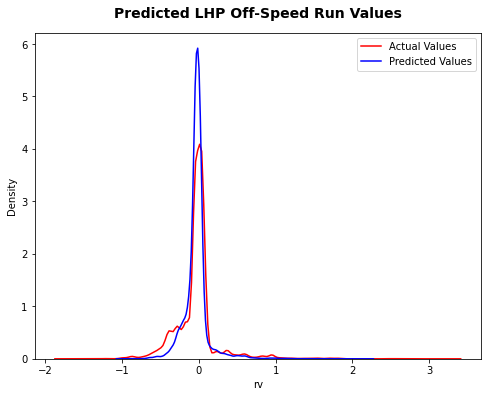

In [142]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off-Speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV Table

In [143]:
lhp_offspeed['CH_count'] = [1 if x == 'CH' else 0 for x in lhp_offspeed['pitch_type']]
lhp_offspeed['FS_count'] = [1 if x == 'FS' else 0 for x in lhp_offspeed['pitch_type']]

lhp_offspeed['xRV'] = pred
lhp_offspeed['xRV'] = round(lhp_offspeed['xRV'], 3)
grouped_os_l = lhp_offspeed.groupby(['player_name', 'pitch_type'], as_index = False)['CH_count', 'FS_count',
                                                                                     'pfx_x', 'pfx_z',
                                                                                     'velo', 'arm_angle',
                                                                                     'release_extension',
                                                                                     'rv', 'xRV'].sum()
grouped_os_l = pd.DataFrame(grouped_os_l)
grouped_os_l['RV/100'] = round(((grouped_os_l['rv'] / (grouped_os_l['CH_count'] +
                                                       grouped_os_l['FS_count'])) * 100), 2)

grouped_os_l['xRV/100'] = round(((grouped_os_l['xRV'] / (grouped_os_l['CH_count'] +
                                                         grouped_os_l['FS_count'])) * 100), 2)

os_l_group = pd.merge(lhp_offspeed, grouped_os_l, how = 'left', on = ['player_name'])
os_l_group.drop(columns = os_drop_cols, inplace = True)
os_l_group.rename(columns = col_dict_os, inplace = True)
os_l_rv_table = os_l_group.groupby(['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count'], 
                                   as_index = False)['velo', 'pfx_x', 'pfx_z', 'arm_angle', 
                                                     'release_extension', 'RV', 
                                                     'RV/100', 'xRV', 'xRV/100'].mean()
os_l_rv_table['velo'] = round(os_l_rv_table['velo'], 1)
os_l_rv_table['pfx_x'] = round(os_l_rv_table['pfx_x'], 2)
os_l_rv_table['pfx_z'] = round(os_l_rv_table['pfx_z'], 2)
os_l_rv_table['arm_angle'] = round(os_l_rv_table['arm_angle'], 2)
os_l_rv_table['release_extension'] = round(os_l_rv_table['release_extension'], 2)

os_l_rv_table = pd.DataFrame(os_l_rv_table)
print(os_l_rv_table.shape)
os_l_rv_table.head()

(186, 14)


,player_name,p_throws,pitch_type,CH_count,FS_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abad, Fernando",L,CH,46,0,75.1,-10.65,14.23,17.7,5.88,-3.578,-7.78,-3.270,-7.11
1,"Aguilar, Miguel",L,CH,3,0,85.8,-14.92,8.88,31.5,6.10,0.046,1.53,0.065,2.17
2,"Akin, Keegan",L,CH,344,0,81.9,-15.27,8.41,83.2,6.03,1.200,0.35,0.034,0.01
3,"Albers, Andrew",L,CH,53,0,80.0,-12.72,7.73,70.2,6.09,-1.046,-1.97,-1.420,-2.68
4,"Alexander, Scott",L,CH,22,0,86.2,-13.59,4.54,57.0,6.12,-0.834,-3.79,-0.744,-3.38


### LHP Off-Speed RV by Strike Zone

In [144]:
#plt.figure(figsize = (8, 6))
#
#plt.hexbin(lhp_offspeed['plate_x'], lhp_offspeed['plate_z'], C = pred, cmap = 'coolwarm', 
#           gridsize = 20, mincnt = 50)
#plt.xlabel('plate_x'), plt.ylabel('plate_z'), plt.colorbar()
#plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
#plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
#plt.title('LHP Off-Speed RV by Strike Zone - Pitcher Perspective', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV by Velo & Spin Rate

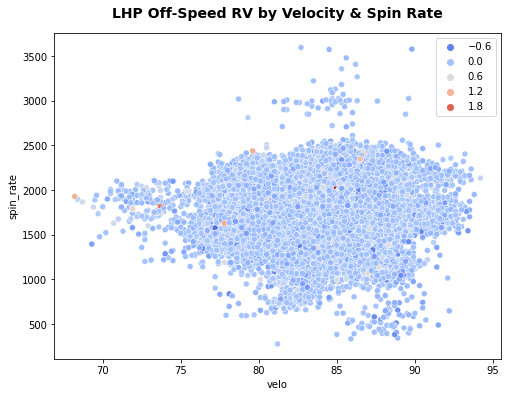

In [145]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_offspeed, x = 'velo', y = 'spin_rate', hue = pred, palette = 'coolwarm')
plt.title('LHP Off-Speed RV by Velocity & Spin Rate', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV by HB & VB

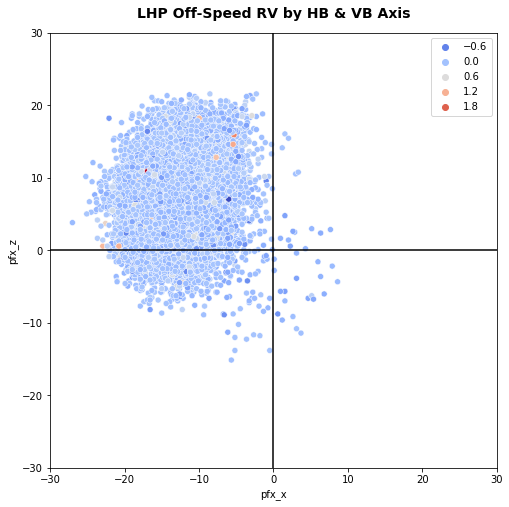

In [146]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = lhp_offspeed, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Off-Speed RV by HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed RV by Release Point

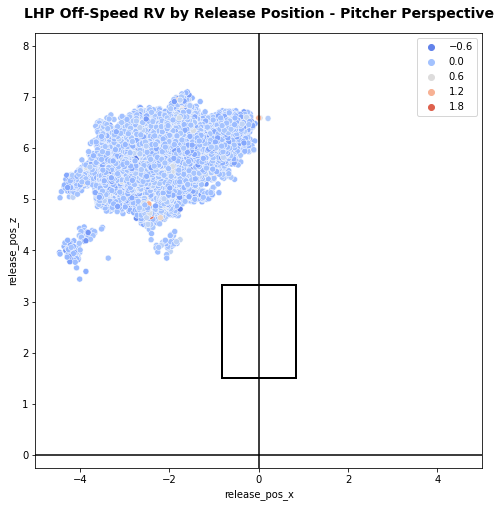

In [147]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = lhp_offspeed, x = 'release_pos_x', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('LHP Off-Speed RV by Release Position - Pitcher Perspective', fontsize=14, fontweight='bold', pad=15);

### LHP Off-Speed RV by Release Extension

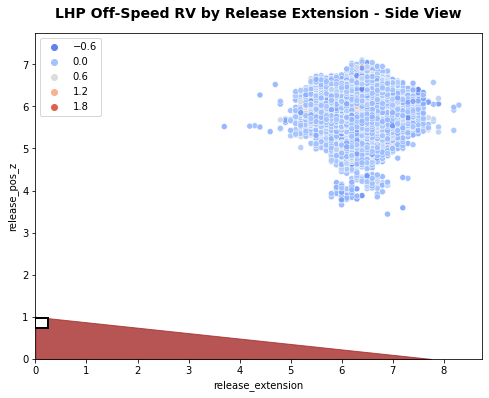

In [148]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = lhp_offspeed, x = 'release_extension', y = 'release_pos_z', 
                hue = pred, palette = 'coolwarm')
plt.xlim(0, 8.75), plt.ylim(0, 7.75)
plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
plt.title('LHP Off-Speed RV by Release Extension - Side View', fontsize = 14, fontweight = 'bold', pad = 15);

### Save RV tables to CSV

In [149]:
xrv_predictions = pd.concat([ff_r, ff_l, fc_r, fc_l, si_r, si_l, sl_r, sl_l, cu_r, cu_l, ch_r, ch_l], 
                        ignore_index = True)
xrv_predictions.to_csv('../data/xrv-pitches.csv')

rv_pitches_table = pd.concat([ff_r_rv_table, ff_l_rv_table, fc_r_rv_table, fc_l_rv_table, si_r_rv_table, 
                              si_l_rv_table, sl_r_rv_table, sl_l_rv_table, cu_r_rv_table, cu_l_rv_table, 
                              ch_r_rv_table, ch_l_rv_table], 
                             ignore_index = True)
rv_pitches_table.to_csv('../data/pitches-rv-table.csv')

rv_grouped_pitches_table = pd.concat([fastball_r_rv_table, fastball_l_rv_table, bb_r_rv_table, bb_l_rv_table, 
                                     os_r_rv_table, os_l_rv_table], ignore_index = True)
rv_grouped_pitches_table.fillna(0, inplace = True)
rv_grouped_pitches_table.to_csv('../data/grouped-pitches-rv-table.csv')